In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from collections import Counter
from sklearn.linear_model import ElasticNetCV
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import lightgbm as lgb

%matplotlib inline

C:\Users\sreej\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filtered_train=pd.read_csv("C:/Users/sreej/OneDrive/Favorites/TRAVELLERS_CASE/Filtered.Train_Dawei Ye.csv")

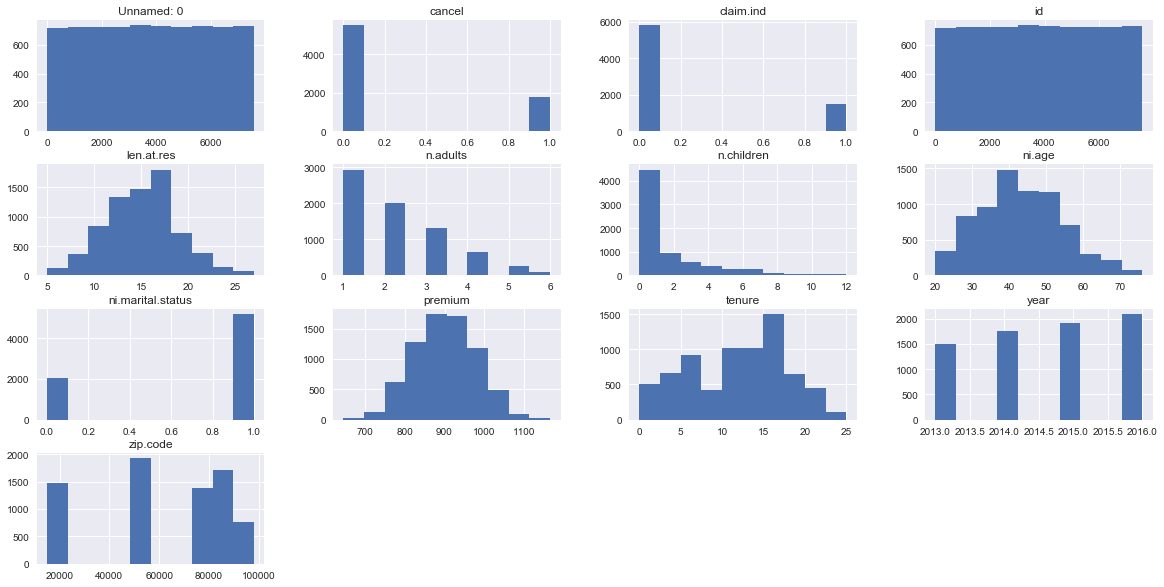

In [3]:
##Checking the distribution of numerical variables

filtered_train.hist(figsize=(20,10))
plt.show()

In [4]:
filtered_test=test=pd.read_csv("C:/Users/sreej/OneDrive/Favorites/TRAVELLERS_CASE/After_test.csv")

In [5]:
IDtest = filtered_test["id"]

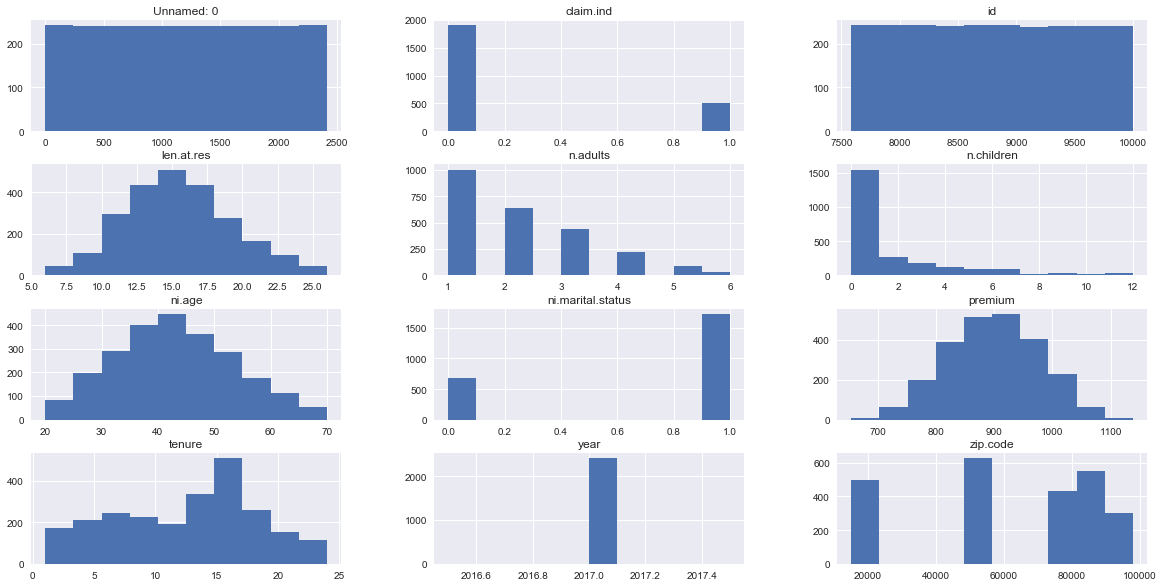

In [6]:
filtered_test.hist(figsize=(20,10))
plt.show()

In [7]:
#checking the number of null values in data set
filtered_test.isnull().sum()

Unnamed: 0           0
id                   0
tenure               0
claim.ind            0
n.adults             0
n.children           0
ni.gender            0
ni.marital.status    0
premium              0
sales.channel        0
coverage.type        0
dwelling.type        0
len.at.res           0
credit               0
house.color          0
ni.age               0
year                 0
zip.code             0
dtype: int64

In [8]:
filtered_train.drop('Unnamed: 0',axis=1,inplace=True)
filtered_test.drop('Unnamed: 0',axis=1,inplace=True)

## I have done feature engineering and preprocessing in other jupyter notebook file.This file shows different types of model implementations

In [9]:
##Since It is Clasiification Label Encoder can be used. But if regression better use Dummies for encoding

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

labelEnc=LabelEncoder()

cat_vars=['ni.gender','sales.channel','coverage.type','dwelling.type','credit','house.color']
for col in cat_vars:
    filtered_train[col]=labelEnc.fit_transform(filtered_train[col])
    filtered_test[col]=labelEnc.fit_transform(filtered_test[col])
    
    

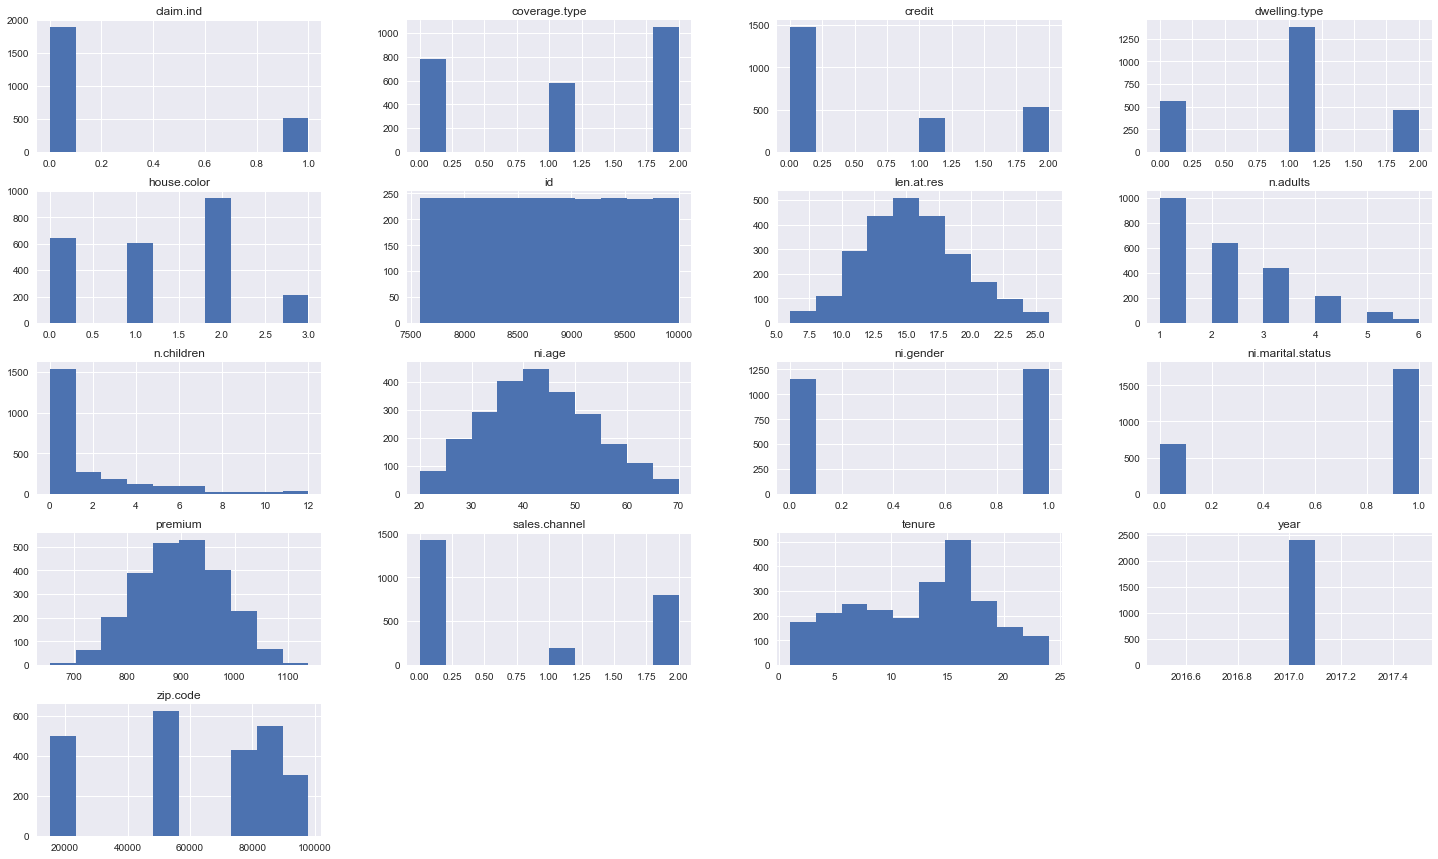

In [10]:
filtered_test.hist(figsize=(25,15))
plt.show()

In [11]:
P=filtered_train[filtered_train.columns.difference(['cancel'])]
Y=filtered_train['cancel']

In [14]:
#Applied Log transform on Premium variable to make it normalised

P['premium']=np.log(P['premium'])


C:\Users\sreej\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


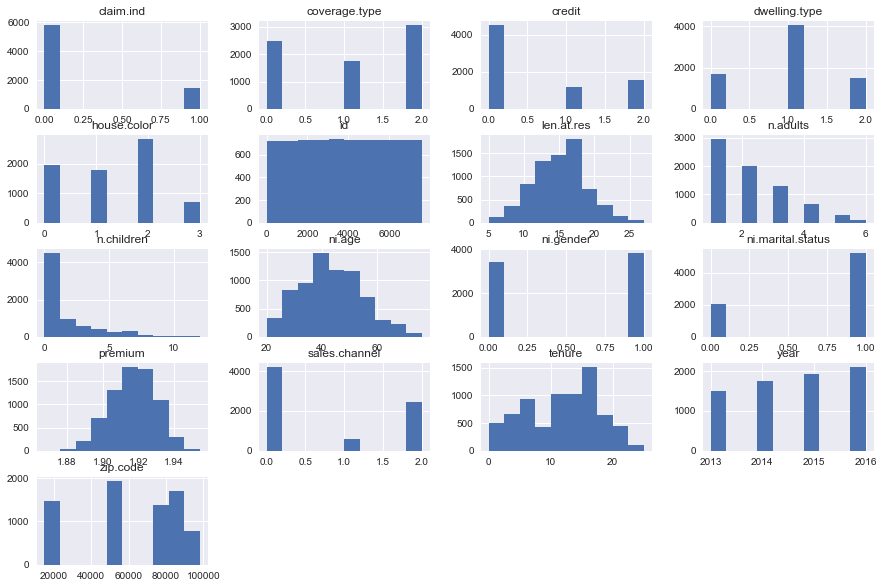

In [15]:
P.hist(figsize=(15,10));

In [16]:
#When I drop unimportant variables
X=P.copy()
X.drop(['id','zip.code'],axis=1,inplace=True)
X.dtypes
filtered_test.dtypes

id                     int64
tenure                 int64
claim.ind              int64
n.adults               int64
n.children             int64
ni.gender              int64
ni.marital.status      int64
premium              float64
sales.channel          int64
coverage.type          int64
dwelling.type          int64
len.at.res             int64
credit                 int64
house.color            int64
ni.age                 int64
year                   int64
zip.code               int64
dtype: object

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.30)

### Initially I try to check variable importance by implementing Ridge and Lasso regression by removing variablee that cause the high variance to the model 

In [20]:
##Ridge regression model

In [19]:
from sklearn.linear_model import Ridge
ridgeReg = Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,Y_train)
pred = ridgeReg.predict(X_test)


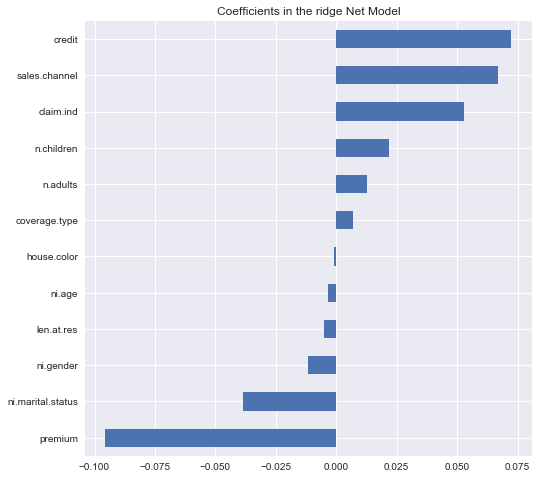

In [21]:
coeff_ridge=pd.Series(ridgeReg.coef_,index = X_train.columns)
imp_coef_ridge = pd.concat([coeff_ridge.sort_values().head(6),
                     coeff_ridge.sort_values().tail(6)])
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
imp_coef_ridge.plot.barh()
plt.title("Coefficients in the ridge Net Model");

## a.Basic Logistic Regression

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict_proba(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

76.730000000000004

In [24]:
Y_PROB_PRED=pd.DataFrame(Y_pred)[1]

In [25]:
##ROC CURVE
fpr1, tpr1, threshold = metrics.roc_curve(Y_test, Y_PROB_PRED)
metrics.auc(fpr1, tpr1)


0.67560804626798832

In [26]:
Y_pred = logreg.predict_proba(X_train)
Y_PROB_PRED=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_train, Y_PROB_PRED)
metrics.auc(fpr1, tpr1)

0.68210224091978988

### My ROC on test is more than mentioned cut off level of 67.2

In [409]:
##ogistic with Kfold and Grid-Search CV

In [28]:
kfold = StratifiedKFold(n_splits=10)

In [29]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
log_clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)


log_clf.fit(X_train,Y_train)
LOG_best = log_clf.best_estimator_
Y_pred=LOG_best.predict_proba(X_test)
Y_PROB_LOG=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_test, Y_PROB_LOG)

metrics.auc(fpr1, tpr1)


0.67513961101482767

In [412]:
##testing on training

Y_pred=LOG_best.predict_proba(X_train)
Y_PROB_LOG=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_train, Y_PROB_LOG)

metrics.auc(fpr1, tpr1)


0.6797794559829845

## Here I compared various models ROC values with basic parameters for all the models

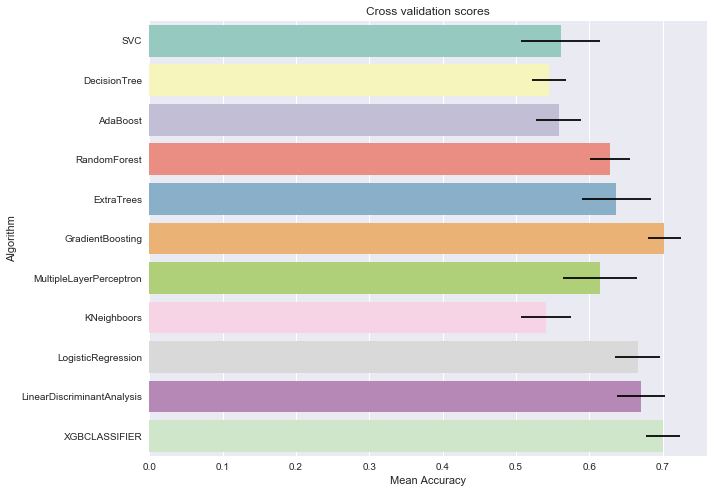

In [30]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier())
#classifiers.append(LGBMClassifier(random_state=random_state))
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_test, y = Y_test, scoring = "roc_auc", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBCLASSIFIER"]})

plt.figure(figsize=(10,8))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
plt.show()

###  I found GBM,XGBOOXT, LOGISTIC giving me good ROC results with basic parameter tuning.Probably tuning parameters in these models may give me good ROC. Lets find Out: 

## 1.Random Forest..with GridSearch Cross Validation with Stratified 10-fold CV

In [31]:
##Please take care of parameter tuning in Random Forest as it may take longer time to train model

In [32]:
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)
gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  8.9min finished


In [35]:
Y_pred=RFC_best.predict_proba(X_train)
Y_PROB_RFM=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_train, Y_PROB_RFM)
metrics.auc(fpr1, tpr1)

0.9487523491715002

In [37]:
Y_pred=RFC_best.predict_proba(X_test)
Y_PROB_RFM=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_test, Y_PROB_RFM)
metrics.auc(fpr1, tpr1)

0.70653450950609831

#### Unfortunately my Random forest tends to over fit a lot when compared to training and test

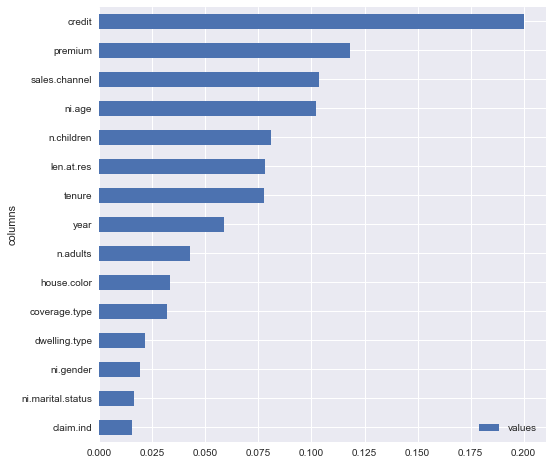

In [46]:
values=pd.DataFrame(RFC_best.feature_importances_)
colms=pd.DataFrame(X.columns,columns={'columns'})
demo=pd.concat([values,colms],axis=1).set_index('columns')
demo.rename(columns={0:'values'},inplace=True)
demo.sort_values('values',ascending=True).plot.barh();

#### From the random forest major split I found that the variables CREDIT SCORE,PREMIUM,SALES CHANNEL, AGE found to be top important variables

## 2.Gradient Boosing Algorithm

### Please find this interesting article on parameter tuning of Gradient Boosting :
    
  https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/  

In [47]:
GBC = GradientBoostingClassifier()
gb_param_grid = {
              'n_estimators' : [40,60,100],
              'learning_rate': [0.1,0.005,0.2],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_
#RFC_best = gsRFC.best_estimator_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.6min finished


In [48]:
gsGBC.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_leaf': 100,
 'n_estimators': 60}

In [49]:
Y_pred=GBC_best.predict_proba(X_test)
Y_PROB_GBM=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_test, Y_PROB_GBM)
metrics.auc(fpr1, tpr1)

0.70991308524656138

In [50]:
Y_pred=GBC_best.predict_proba(X_train)
Y_PROB_GBM=pd.DataFrame(Y_pred)[1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_train, Y_PROB_GBM)
metrics.auc(fpr1, tpr1)

0.77687857577040587

## 3.XGBOOST CLASSIFIER

#### Pease find interesting article on parameter tuning in Xgboost:
    
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [51]:
xgb_model = xgb.XGBClassifier()

parameters = { #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.05, 0.01], #so called `eta` value
              'max_depth': [4,8,6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [500], #number of trees, change it to 1000 for better results
             }

clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=kfold,scoring='roc_auc',verbose=2, refit=True)
        
clf.fit(X_train, Y_train)

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
    
XGB_best = clf.best_estimator_


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:  2.4min finished


Raw AUC score: 0.715881202015
colsample_bytree: 0.7
learning_rate: 0.01
max_depth: 4
min_child_weight: 11
n_estimators: 500
objective: 'binary:logistic'
silent: 1
subsample: 0.8


C:\Users\sreej\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [52]:
test_probs = XGB_best.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_test, test_probs)
metrics.auc(fpr1, tpr1)

0.71538285115875522

In [53]:
test_probs = XGB_best.predict_proba(X_train)[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_train, test_probs)
metrics.auc(fpr1, tpr1)

0.78063317491305773

## 4.Light GBM Classifier

## This is one of the fastest execution time model and best in parameter tuning. 

Please find the easy implementation of this model in this article:
    
https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

In [55]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

In [58]:
params = {
    'task': 'train',
    'boosting_type': 'rf',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'max_depth': [6],
    'num_leaves': 150,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
l_gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
    
pred=l_gbm.predict(X_train, num_iteration=l_gbm.best_iteration)

fpr1, tpr1, threshold = metrics.roc_curve(Y_train, pred)
roc_auc_lbgm = metrics.auc(fpr1, tpr1)
roc_auc_lbgm

Start training...
[1]	valid_0's auc: 0.668592	valid_0's l2: 0.181061
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.670785	valid_0's l2: 0.181789
[3]	valid_0's auc: 0.658471	valid_0's l2: 0.18401
[4]	valid_0's auc: 0.675184	valid_0's l2: 0.180938
[5]	valid_0's auc: 0.688136	valid_0's l2: 0.179431
[6]	valid_0's auc: 0.692634	valid_0's l2: 0.178656
[7]	valid_0's auc: 0.695275	valid_0's l2: 0.178321
[8]	valid_0's auc: 0.696233	valid_0's l2: 0.177953
[9]	valid_0's auc: 0.693966	valid_0's l2: 0.178029
[10]	valid_0's auc: 0.693411	valid_0's l2: 0.178025
[11]	valid_0's auc: 0.695104	valid_0's l2: 0.177899
[12]	valid_0's auc: 0.69537	valid_0's l2: 0.177752
[13]	valid_0's auc: 0.695207	valid_0's l2: 0.177794
Early stopping, best iteration is:
[8]	valid_0's auc: 0.696233	valid_0's l2: 0.177953


0.7726812749636337

In [57]:
pred=l_gbm.predict(X_test, num_iteration=l_gbm.best_iteration)

fpr1, tpr1, threshold = metrics.roc_curve(Y_test, pred)
roc_auc_lbgm = metrics.auc(fpr1, tpr1)
roc_auc_lbgm

0.69623272036470873

## Here I have used a Voting Classifier to give a least over fitted and optimised prediction score

In [394]:
###voting classifierr

In [71]:
votingC = VotingClassifier(estimators=[ ('xgb',XGB_best),('gbc',GBC_best),('log',LOG_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

In [73]:
Y_PRED_VOTNG=votingC.predict_proba(X_test)[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(Y_test, Y_PRED_VOTNG)
metrics.auc(fpr1, tpr1)

0.71278211594259344

## My best ROC score after using VotingC is 0.71 

In [62]:
filtered_test.drop(['id','zip.code'],inplace=True,axis=1)
filtered_test=filtered_test.reindex_axis(sorted(filtered_test.columns), axis=1)

In [63]:
test_Survived = pd.Series(votingC.predict_proba(filtered_test)[:,1], name="prediction")

results = pd.concat([IDtest,test_Survived],axis=1)


In [459]:
results.to_csv("C:/Users/sreej/Desktop/TEAM_TATORS_SUBMISSION1.csv")

References :
    
    
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling